### Ages (with DP)

\begin{tabular}{l r r r }
$N$  & Simple  & Centroid  & Integral \\
\hline
2 & $6.71$ & $2.58$ & $2.60$\\
3 & $5.99$ & $1.94$ & $1.96$\\
5 & $5.53$ & $1.70$ & $1.70$\\
8 & $5.23$ & $1.70$ & $1.69$\\
12 & $4.93$ & $2.17$ & $2.14$\\
17 & $5.00$ & $2.01$ & $1.98$\\
23 & $4.50$ & $2.87$ & $2.86$\\
30 & $4.31$ & $3.38$ & $3.38$\\

\hline
\end{tabular}


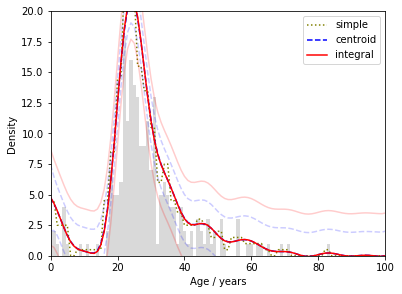

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import GPy
from dp4gp.centroid_histogram import DPGP_centroid_histogram
from dp4gp.integral_histogram import DPGP_integral_histogram
from dp4gp.histogram import DPGP_histogram
from dp4gp.utils import bin_hist

#ages = np.array([[6,2,1,0,4,1,0,0,0,1,0,1,0,0,1,0,0,2,7,35,5,6,18,11,16,14,13,9,9,11,7,13,1,5,6,5,4,4,1,4,2,1,2,0,3,2,1,3,1,2,0,3,1,0,0,0,3,0,0,1,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]).T
ages = np.array([[6,2,1,0,4,1,0,0,0,1,0,1,0,0,1,0,0,2,7,5,5,6,18,11,16,14,13,9,9,11,7,13,1,5,6,5,4,4,1,4,2,1,2,0,3,2,1,3,1,2,0,3,1,0,0,0,3,0,0,1,1,0,1,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]).T
#logages = np.log(0.0025+ages)
spacing = 15
def gen_bins(data,spacing):
    bin_ranges = np.arange(0,101+spacing,spacing)
    original_ranges = np.array(range(len(data)))
    return bin_ranges,bin_hist(data,original_ranges,bin_ranges)

def plotresult(dpgptype,eps,color,leg,ls,plot=True,stepsize = 2):
    dpgp = dpgptype(1.0,eps,0.01)
    
    Xtest = np.arange(0,len(ages),stepsize)[:,None]
    X = np.arange(0,len(ages))[:,None]
    steps = [stepsize]
    bincounts, bintotals, binaverages, sens_per_bin, bin_sigma, dp_binaverages = \
        dpgp.prepare_model(Xtest,X,steps,ages,lengthscale=10,variances=20,aggregation='density',mechanism='laplace',scaling=1)
    if dpgptype==DPGP_integral_histogram:
        dpgp.model.Gaussian_noise = 0.5 #start at 0.5???
    dpgp.optimize(messages=False)
    #print(dpgp.model)
    #if dpgptype==DPGP_centroid_histogram:
    #    dpgp.model.sum.rbf.lengthscale = 11.6
    #    dpgp.model.Gaussian_noise = 0.100
    #    dpgp.model.sum.rbf.variance = 12.14

    Xtests = np.arange(0,101)[:,None]
    #logpreds,cov = dpgp.draw_prediction_samples(Xtests)
    preds,cov = dpgp.draw_prediction_samples(Xtests)
    #preds=np.exp(logpreds)
    if plot: plt.plot(Xtests[:,0],preds,color=color,ls=ls,label=leg)
    propinci = None
    if cov is not None:
        stes = np.sqrt(cov)*1.96
   #     if plot: plt.plot(Xtests[:,0],preds+stes,color=1-(1-color)*0.3)
   #     if plot: plt.plot(Xtests[:,0],preds-stes,color=1-(1-color)*0.3)    
        if plot: plt.plot(Xtests[:,0],preds+stes,ls=ls,color=color,alpha=0.2)
        if plot: plt.plot(Xtests[:,0],preds-stes,ls=ls,color=color,alpha=0.2)
   #     plt.plot(Xtests[:,0],np.exp(logpreds+stes),color=color,alpha=0.2)
   #     plt.plot(Xtests[:,0],np.exp(logpreds-stes),color=color,alpha=0.2)
        #propinci = (np.mean((ages<preds+stes) & (ages>preds-stes)))
   # rmse = np.sqrt(np.mean((preds-ages)**2))
   # mae = np.mean(np.abs(preds-ages))
    #print(dpgptype)
    #print(rmse,mae,propinci)
    return dpgp,preds,cov

plt.figure(figsize=[6,4.5])
plt.bar(np.arange(0,101),ages[:,0],np.ones(101),color=(0.85,0.85,0.85))
#plt.step(np.arange(0,101)-0.5,ages[:,0],np.ones(101),color=(0.5,0.5,0.5),where='post')

eps = 10000 #for plot

methodnames = ["Simple","Centroid","Integral"]
methods = [DPGP_histogram,DPGP_centroid_histogram,DPGP_integral_histogram]
colors = [np.array([0.5,0.5,0]),np.array([0,0,1]),np.array([1,0,0])]
linestyles = [':','--','-']
legends = ['simple','centroid','integral']
allpred = []
for method,col,leg,ls in zip(methods,colors,legends,linestyles):
    dpgp,preds,covs=plotresult(method,10000,col,ls=ls,leg=leg)
plt.legend()
plt.ylim([0,20])
plt.xlabel('Age / years')
plt.ylabel('Density')
plt.xlim([0,100])
plt.savefig('dp_ages_example.pdf')

if True:
    print("\\begin{tabular}{l r r r }")
    print("$N$ ",end="")
    for name in methodnames:
        #print(" & \multicolumn{1}{c}{%s} " % name,end="")
        print(" & %s " % name,end="")
    print("\\\\\n\\hline")
    #for eps in [0.05,0.1,0.2,0.5,1,2,5,10,1000]:
    #for eps in [50]:
    eps = 1
    for stepsize in [2,3,5,8,12,17,23,30]: #np.arange(2,30,2):
        print("%0.0f & " % stepsize,end="")
        for methodi,(method,col,leg) in enumerate(zip(methods,colors,legends)):
            MAE = []
            RMSE = []
            for i in range(100):
                dpgp,preds,covs=plotresult(method,eps,col,leg=leg,ls='-',plot=False,stepsize=stepsize)
                errs = np.array(ages-preds.tolist())
                MAE.append(np.mean(np.abs(errs)))
                RMSE.append(np.sqrt(np.mean(errs**2)))
            print("$%0.2f$" % (np.mean(RMSE)),end="")
            if (methodi<len(colors)-1):
                print(" & ",end="")
            
        print("\\\\")
    print("\n\\hline")    
    print("\\end{tabular}")

\begin{tabular}{l r r r }
$N$  & Simple  & Centroid  & Integral \\
\hline
2 & $6.71$ & $2.58$ & $2.60$\\
3 & $5.99$ & $1.94$ & $1.96$\\
5 & $5.53$ & $1.70$ & $1.70$\\
8 & $5.23$ & $1.70$ & $1.69$\\
12 & $4.93$ & $2.17$ & $2.14$\\
17 & $5.00$ & $2.01$ & $1.98$\\
23 & $4.50$ & $2.87$ & $2.86$\\
30 & $4.31$ & $3.38$ & $3.38$\\

\hline
\end{tabular}

In [ ]:
plt.plot(ages,preds,'+')
summary = []
for a,p,st in zip(ages,preds,np.sqrt(covs)):
    #plt.plot([a,a],[p-st*2,p+st*2],'-k+')
    summary.append((a-p)/st)
print(np.mean(summary),np.std(summary) )
plt.plot([0,20],[0,20],'b-')


In [19]:
from scipy.stats import norm
1-(2*(1-norm.cdf(1,0,1)))

0.6826894921370859

-0.1296776289535113

In [32]:
np.std(np.mean(np.random.choice(RMSE,size=[len(RMSE),10000]),0))

1.1599664873624964e-06

## Citibike (no DP) 4d

In [ ]:
import GPy
from dp4gp import datasets
df = datasets.load_citibike(station=None)
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

d = datetime.strptime(df.starttime[0],'%m/%d/%Y %H:%M:%S')
Ntesting = 1000
df = df.sample(10000)
df = df[2000:]
datasets.add_citibike_extra_columns(df)

def meanabserror(pred,act):
    return np.mean(np.abs(pred-act))

def rmse(pred,act):
    return np.sqrt(np.mean((pred-act)**2))

def buildgrid(rawinputs,rawoutputs,N):
    """
    buildgrid(df,inputcols,outputcol,N)
        df        - dataframe
        inputcols - names of columns of df to use as inputs
        outputcol - name of column we're averaging into bins
        N         - list of number of boundaries for each dimension (should be same length as inputcols)
    """

    binmins = np.min(rawinputs,0)
    binmaxs = np.max(rawinputs,0)
    ranges = []
    for (ri,rmin,rmax,Ni) in zip(rawinputs.T,binmins,binmaxs,N): #loops through dimensions.
        ran = np.linspace(rmin,rmax,Ni)
        ranges.append(ran)


    currentinput = None
    for rang in ranges:
        newinput = np.c_[rang[1:],rang[:-1]]
        if currentinput is None:
            currentinput = newinput.copy()
        else:
            temp = newinput.copy()
            for i in range(len(currentinput)-1):
                temp = np.r_[temp,newinput]
            currentinput = np.c_[currentinput.repeat(len(newinput),0),temp]

    output = np.zeros(len(currentinput))
    outputcount = np.zeros(len(currentinput))
    for rin,rout in zip(rawinputs,rawoutputs):
        loc = [True]*len(currentinput)
        for dim in range(len(rin)):
            loc &= ((rin[dim]<currentinput[:,dim*2]) & (rin[dim]>currentinput[:,dim*2+1]))
        output[loc]+=rout
        outputcount[loc]+=1
    stepsizes = currentinput[0,0::2]-currentinput[0,1::2]
    return currentinput, output, outputcount, stepsizes, rawinputs, rawoutputs

inputcols = ['start station latitude','end station longitude','end station latitude','end station longitude']
outputcol = ['tripduration']

# strip out journeys over 2 hours.
df = df[df[outputcol].values<(3600*2)]
df = df[df['end station latitude']>=40.6]

results = {}
rmse_results = {}
for Ntraining in [160,320,640,1280,2560]:
    for Nsteps in [2,4,8,16]:

        rawoutputs = df[outputcol].values[0:Ntraining,:]
        outmean = np.mean(rawoutputs)
        rawoutputs = rawoutputs - outmean
        areainputs,outputs,outputcounts,stepsizes, rins, routs = buildgrid(df[inputcols].values[0:Ntraining,:], rawoutputs, [Nsteps,Nsteps,Nsteps,Nsteps])

        #get rid of empty tiles (these won't tell us much)
        keep = outputcounts>0
        areainputs = areainputs[keep,:]
        outputs = outputs[keep]
        outputcounts = outputcounts[keep]
        #get into units of density
        out = (outputs/outputcounts)[:,None]*np.prod(stepsizes)
        #!!! SCALE TO TENTHS OF DEGREES RATHER THAN DEGREES!
        areainputs*=10
        out*=10**4


        kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=areainputs.shape[1],lengthscale=[1,1,1,1],variances=[1])
        m = GPy.models.GPRegression(areainputs,out,kernel,normalizer=None)
        sel = (areainputs[:,4]>407.4) & (areainputs[:,4]<407.6) & (areainputs[:,6]>-739.7) & (areainputs[:,6]<-739.6)
        centroidinputs = (areainputs[:,::2]+areainputs[:,1::2])/2
        kernel_simple = GPy.kern.RBF(input_dim=centroidinputs.shape[1],lengthscale=1,variance=1,ARD=False)
        m_simple = GPy.models.GPRegression(centroidinputs,out,kernel_simple,normalizer=False)

        testn = 1000
        testX = np.zeros([testn,8])
        testX[:,0::2] = 10*df[inputcols].values[3000:(3000+testn),:]
        testX_simple = 10*df[inputcols].values[3000:(3000+testn),:]
        testY = df[outputcol].values[3000:(3000+testn),:]

        print(Ntraining,Nsteps)
        ##################################################
        #2980.9579870417283, 0.14956861922263512, 2.0611536224385579e-09
        #numbers from separate grid search
        m.integral.variance = 2980.957
        m.integral.lengthscale = 0.149#0.223 #0.149
        m.Gaussian_noise = 2.061e-09
        m_simple.kern.variance = 0.00012340980408667956
        m_simple.kern.lengthscale = 0.149#0.22313016014842982
        m_simple.Gaussian_noise = 4.1399377187851668e-08

        #m_simple.optimize()
        means_simple, _ = m_simple.predict_noiseless(testX_simple)

        preds = means_simple/(10**4)/np.prod(stepsizes)+outmean
        mae_simple = meanabserror(preds,testY)
        rmse_simple = rmse(preds,testY)
        #print("Simple Method: %0.2f" % mae_simple)
        print("Simple Method: %0.2f" % rmse_simple)
        

        #m.optimize()
        means, _ = m.predict_noiseless(testX)
        preds = means+outmean
        mae_integral = meanabserror(preds,testY)
        rmse_integral = rmse(preds,testY)
        #print("Integral Method: %0.2f" % mae_integral)
        print("Integral Method: %0.2f" % rmse_integral)
        #results[(Ntraining,Nsteps)] = {'integral':mae_integral, 'simple':mae_simple}
        rmse_results[(Ntraining,Nsteps)] = {'integral':rmse_integral, 'simple':rmse_simple}

In [36]:
import pickle
#pickle.dump(rmse_results,open('citibikermseresults.p','wb'))
rmse_results = pickle.load(open('citibikeresults.p','rb'))

In [37]:
rmse_results

{(160, 2): {'integral': 491.2897249397727, 'simple': 495.56313227739474},
 (160, 4): {'integral': 435.46244052619676, 'simple': 438.05855583553495},
 (160, 8): {'integral': 452.6480812869829, 'simple': 524.6291284339057},
 (160, 16): {'integral': 489.0969364449568, 'simple': 739.4381011236684},
 (320, 2): {'integral': 490.9495548859419, 'simple': 493.5365514255616},
 (320, 4): {'integral': 433.6396337724415, 'simple': 441.66606931583175},
 (320, 8): {'integral': 381.8219336077844, 'simple': 414.7491402180571},
 (320, 16): {'integral': 481.4827261518607, 'simple': 590.224850184265},
 (640, 2): {'integral': 496.7030073771137, 'simple': 497.03792120319434},
 (640, 4): {'integral': 410.38598097482105, 'simple': 443.9350500188359},
 (640, 8): {'integral': 383.76834719036844, 'simple': 401.6140865237215},
 (640, 16): {'integral': 479.3693737824012, 'simple': 565.021966403065},
 (1280, 2): {'integral': 497.23889125746337, 'simple': 497.61366972181145},
 (1280, 4): {'integral': 396.03714545458

In [ ]:
stepoptions = [2,4,8,16]
trainingoptions = [160,320,640,1280,2560]
#confusingly I've called 'simple' here what was 'centroid' previously
print("\\begin{tabular}{l "+"r "*(2*len(stepoptions))+"}")
print(" & \multicolumn{%d}{c}{Number of bins}\\\\" % (len(stepoptions)*2))
print(" ",end="")



for Nsteps in stepoptions:
    print(" & \multicolumn{2}{c}{${%d^4}$}" % (Nsteps-1),end="")
print("\\\\")
print("Samples",end="")
for Nsteps in stepoptions:
    print(" & centroid & integral",end="")
print("\\\\")    
print("\\hline")
for Ntraining in trainingoptions:
    print("%d" % Ntraining, end="")
    for Nsteps in stepoptions:
        print(" & %0.1f & %0.1f" % (rmse_results[Ntraining,Nsteps]['simple'],rmse_results[Ntraining,Nsteps]['integral']),end="")
    print("\\\\")
print("\\hline")    
print("\\end{tabular}")

# Audience Example (predict the integral not the density)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy
%matplotlib inline

def generate_sim(roughsize):
    df = pd.read_csv('ageincomeus.csv',index_col=0)
    sim = np.zeros([0,3])
    for income,counts in df.iterrows():
        #print("---")
        #print("Income: %d" % income)
        for age,agestep,count in zip(df.columns[0:-1],df.columns[1:],counts):
            #print("%d -> %d, " % (int(age),count))
            N = int((roughsize/84450)*count)

            std = 300 #+/-100 days
            meanstarttime = int(age)*5#-income/5000 #younger people start first
            N = int(N * 40/(int(age)-10))            #we add a bias towards young people
            simtimes = np.random.randn(N)*std + meanstarttime
            simtimes[simtimes>=599] = 599
            simtimes[simtimes<=0] = 0
            simtimes = [np.random.randint(t,600) for t in simtimes]
            simincomes = np.random.randint(income,income+5000,N)
            simages = np.random.randint(int(age),int(agestep),N)        
            sim = np.r_[sim,np.c_[simincomes,simages,simtimes]]
    return sim

def getcount(X,sim):
    """
        Pass boundaries of simulated data to count, e.g.
        X = np.array([[30000,20000,50,30,300,0]]) 
    """
    res = []
    for x in X:
        inc = np.full(sim.shape[0],True)
        for i in range(sim.shape[1]):
            inc &= (sim[:,i]<x[i*2]) & (sim[:,i]>x[i*2+1])
        res.append(np.sum(inc))
    return np.array(res)

X = np.array([[50e3,20e3,70,60,400,0],[100e3,40e3,50,30,300,0],[210e3,0,30,20,250,0],[75e3,30e3,50,45,200,0],[170e3,50e3,40,20,450,0],[25e3,0,70,20,200,0],[25e3,0,70,20,400,0],[150e3,20e3,55,25,480,0]])
sim=generate_sim(5000)
counts = getcount(X,sim)

In [51]:
sim.shape

(5802, 3)

[ 400.    0.   70.   60.   50.   20.]
[ 300.    0.   50.   30.  100.   40.]
[ 250.    0.   30.   20.  210.    0.]
[ 200.    0.   50.   45.   75.   30.]
[ 450.    0.   40.   20.  170.   50.]
[ 200.    0.   70.   20.   25.    0.]
[ 400.    0.   70.   20.   25.    0.]
[ 480.    0.   55.   25.  150.   20.]


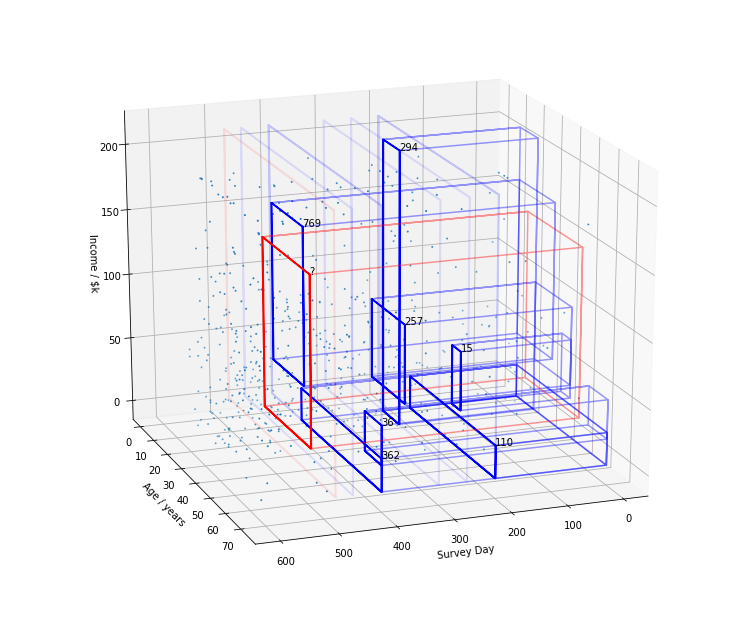

In [3]:
from mpl_toolkits import mplot3d
#%matplotlib notebook
%matplotlib inline


def drawcuboid(ax,l,s,c="b",alpha=1):
    ax.plot3D(l[0]+np.array([0,1,1,0,0,1,1,0,0,0,0,0,1,1,1,1])*s[0],l[1]+np.array([0,0,1,1,1,1,0,0,1,1,0,0,0,0,1,1])*s[1],l[2]+np.array([0,0,0,0,1,1,1,1,1,0,0,1,1,0,0,1])*s[2], color=c, alpha=alpha)

def drawsystem(ax,X,counts,sim):
    ax.scatter3D(sim[::10,2],sim[::10,1],sim[::10,0]/1000,s=1, cmap='Greens')
    countstrings = [str(c) for c in counts]
    countstrings[-1]='?'
    for xv,c in zip(X,countstrings):
        x = xv[[4,5,2,3,0,1]].copy()
        x[4:]/=1000
        #x[1]=x[0]-1
        print(x)
        col = 'b'
        if c=='?': col = 'r'
        drawcuboid(ax,x[1::2],x[0::2]-x[1::2],col,0.4)
        ax.text3D(x[0],x[2],x[4],c)

        x[1]=x[0]-1
        drawcuboid(ax,x[1::2],x[0::2]-x[1::2],col)

        x[2]=0
        x[3]=70
        x[4]=0
        x[5]=210
        drawcuboid(ax,x[1::2],x[0::2]-x[1::2],col,0.1)

fig = plt.figure(figsize=[13,11])
ax = plt.axes(projection='3d')
ax.view_init(20, 70)
drawsystem(ax,X,counts,sim)
plt.xlabel('Survey Day')
plt.ylabel('Age / years')
ax.set_zlabel('Income / $k')
plt.savefig("audiencedemo.pdf")

In [22]:
import numpy as np
from integral_output_observed import Integral_Output_Observed
import GPy

def getpred(X,counts):
    volumes = np.prod(X[:,::2]-X[:,1::2],1)
    meandensity = np.mean(counts/volumes)
    meandensity = 0 #setting to zero disables mean subtraction
    normed_counts = counts - meandensity*volumes


    Xtest = X[-1:,:]
    Xtrain = X[0:-1,:]
    Ytest = counts[-1:,None]
    Ytrain = normed_counts[0:-1,None]
    kernel = Integral_Output_Observed(input_dim=Xtrain.shape[1], variances=1, ARD=True, lengthscale=5*np.std(Xtrain,0)[::2])

    m = GPy.models.GPRegression(Xtrain,Ytrain,kernel)
    m.optimize(messages=False)
    pred, var = m.predict(np.array(Xtest))
    pred+=meandensity*volumes[-1]
    return pred,var,m

pred,var,m = getpred(X,counts)
print("Prediction:")
print("%0.2f +/- %0.2f [std]" % (pred,np.sqrt(var)))
print("95\% CI:")
print("%0.2f-%0.2f" % (pred-np.sqrt(var)*1.96,pred+np.sqrt(var)*1.96))
print("Actual")
print(counts[-1])
#got data from https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-finc/finc-02.2016.html
print(m)
print(m.kern.lengthscale)
    


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


Prediction:
159.35 +/- 48.14 [std]
95\% CI:
65.00-253.70
Actual
96

Name : GP regression
Objective : 69.19011274508229
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  integral.variances       |  6.32813739036e-13  |      +ve      |        
  integral.lengthscale     |               (3,)  |      +ve      |        
  Gaussian_noise.variance  |      108.045780747  |      +ve      |        
  index  |  GP_regression.integral.lengthscale  |  constraints  |  priors
  [0]    |                     270087.57256582  |      +ve      |        
  [1]    |                         21.23053315  |      +ve      |        
  [2]    |                        227.94563849  |      +ve      |        


In [23]:
def getcentroidpred(X,counts):
    Xtest = X[-1:,:]
    Xtrain = X[0:-1,:]
    volumes = np.prod(X[:,::2]-X[:,1::2],1)
    XcentroidsTrain = (Xtrain[:,::2]+Xtrain[:,1::2])/2
    XcentroidsTest = (Xtest[-1:,::2]+Xtrain[-1:,1::2])/2
    Ycentroids = 1e8*counts / volumes
    YcentroidsTrain = Ycentroids[0:-1,None]
    k = GPy.kern.RBF(XcentroidsTest.shape[1],ARD=True,lengthscale=5*np.std(XcentroidsTrain,0))
    m = GPy.models.GPRegression(XcentroidsTrain,YcentroidsTrain,k)
    m.optimize()
    pred,var = m.predict(XcentroidsTest)
    pred = 1e-8*pred*volumes[-1]
    var = 1e-16*var*volumes[-1]**2    
    return pred,var,m

pred,var,m = getcentroidpred(X,counts)
print(pred,var)

print("Prediction:")
print("%0.2f +/- %0.2f [std]" % (pred,np.sqrt(var)))
print("95\% CI:")
print("%0.2f-%0.2f" % (pred-np.sqrt(var)*1.96,pred+np.sqrt(var)*1.96))
print("Actual")
print(counts[-1])
#got data from https://www.census.gov/data/tables/time-series/demo/income-poverty/cps-finc/finc-02.2016.html
print(m)
print(m.rbf.lengthscale)

[[ 169.55859471]] [[ 13131.74157056]]
Prediction:
169.56 +/- 114.59 [std]
95\% CI:
-55.05-394.16
Actual
96

Name : GP regression
Objective : 76.12571291553921
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |          value  |  constraints  |  priors
  rbf.variance             |  3140.83594195  |      +ve      |        
  rbf.lengthscale          |           (3,)  |      +ve      |        
  Gaussian_noise.variance  |  922.694368391  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                215981.73495359  |      +ve      |        
  [1]    |                   100.34113401  |      +ve      |        
  [2]    |                   228.43274677  |      +ve      |        


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:236: RuntimeWarning:invalid value encountered in true_divide


[ 449.       0.      55.      20.     177.584   50.131]
[ 589.       0.      62.      20.     155.795   24.316]
[ 399.       0.      58.      35.     187.756   70.931]
[ 378.       0.      45.      23.     158.548  107.379]
[ 408.       0.      59.      37.     123.807   32.913]
[ 341.       0.      53.      32.      90.369   33.39 ]
[ 357.       0.      67.      28.      97.553   36.86 ]


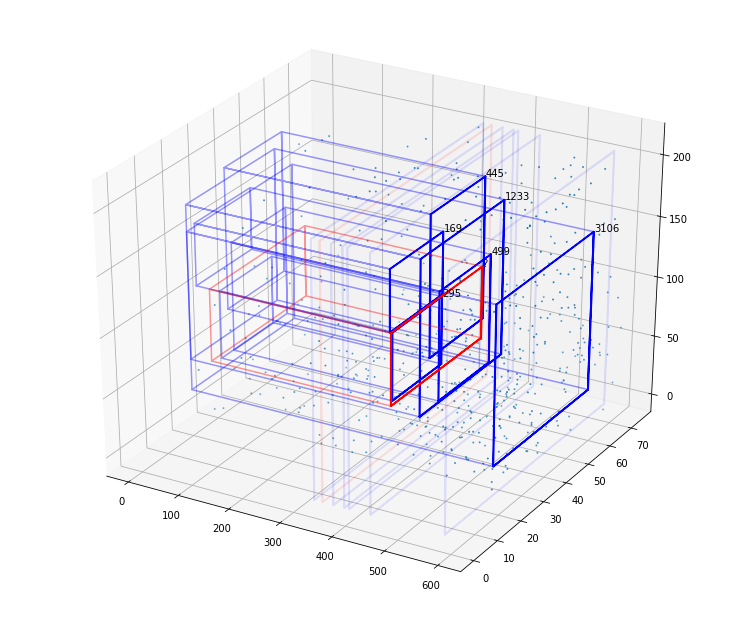

In [26]:
def gensimulatedsurveys():
    X = []
    for it in range(np.random.randint(6,20)):
        topincome = np.random.randint(61e3,210e3)
        bottomincome = np.random.randint(10e3,topincome-50e3)
        topage = np.random.randint(45,70)
        bottomage = np.random.randint(20,topage-20)
        timeofsurvey = np.random.randint(100,600)
        X.append([topincome,bottomincome,topage,bottomage,timeofsurvey,0])
    X = np.array(X)*1.0
    counts = getcount(X,sim)
    return X,counts
X,counts = gensimulatedsurveys()

fig = plt.figure(figsize=[13,11])
ax = plt.axes(projection='3d')
drawsystem(ax,X,counts,sim)

In [38]:

#ierrs = []
#cerrs = []
#ivars = []
#cvars = []
for test in range(2500):
    if test%10==0:
        print(test)
    try:
        X,counts = gensimulatedsurveys()
        cpred,cvar,cm = getcentroidpred(X,counts)
        ipred,ivar,im = getpred(X,counts)
        cerrs.append(cpred[0,0]-counts[-1])
        ierrs.append(ipred[0,0]-counts[-1])
        cvars.append(cvar)
        ivars.append(ivar)
    except np.linalg.LinAlgError:
        print("Failed to fit!")

0


 /home/mike/anaconda3/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:136: RuntimeWarning:overflow encountered in square
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:invalid value encountered in add
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:165: RuntimeWarning:overflow encountered in true_divide
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:236: RuntimeWarning:invalid value encountered in true_divide
 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/integral_output_observed.py:82: RuntimeWarning:overflow encountered in double_scalars
 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/integral_output_observed.py:82: RuntimeWarning:invalid value encountered in d

10


 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/integral_output_observed.py:70: RuntimeWarning:overflow encountered in double_scalars
 /home/mike/Documents/Research/SheffieldMLpublications/publications/integralkernel/jupyter/integral_output_observed.py:37: RuntimeWarning:overflow encountered in double_scalars


20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230


 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in multiply
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in add
 /home/mike/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

In [39]:
print("")
print(np.sqrt(np.mean(np.array(ierrs)**2)),np.sqrt(np.mean(np.array(cerrs)**2)))
print(np.mean(np.abs(ierrs)),np.mean(np.abs(cerrs)))


126.253845557 223.091823005
73.0605406319 143.52417423


In [40]:
#ivars = np.array(ivars)[:,0,0]
#cvars = np.array(cvars)[:,0,0]
#np.mean(np.abs(ierrs/np.sqrt(ivars))<1.96)
#np.mean(np.abs(cerrs/np.sqrt(cvars))<1.96)

In [41]:
import pickle
pickle.dump({'cerrs':cerrs,'ierrs':ierrs},open('audience_results_final.p','wb'))

In [42]:
#d = pickle.load(open('audience_results_HALFDONE.p','rb'))
#cerrs = d['cerrs']
#ierrs = d['ierrs']
#d = pickle.load(open('audience_results_OTHERHALFDONE.p','rb'))
#cerrs.extend(d['cerrs'])
#ierrs.extend(d['ierrs'])

In [43]:
len(cerrs)

1998

In [46]:
def bootstrap(errs):
    bstraps = 100000
    maes = np.mean(np.abs(np.random.choice(errs,[len(errs),bstraps])),0)
    rmses = np.sqrt(np.mean((np.random.choice(errs,[len(errs),bstraps]))**2,0))
    return np.mean(rmses),np.std(rmses),np.mean(maes),np.std(maes)
irmse,irmsestd,imae,imaestd = bootstrap(ierrs)
crmse,crmsestd,cmae,cmaestd = bootstrap(cerrs)

In [49]:
print("\\begin{tabular}{l r r}")
print("\\hline")
print("Method & \multicolumn{2}{c}{Method} \\\\")
print(" & Integral & Centroid \\\\")
print("\\hline")
print("RMSE & %0.1f $\pm$ %0.2f & %0.1f $\pm$ %0.2f \\\\" % (np.sqrt(np.mean(np.array(ierrs)**2)),1.96*irmsestd,np.sqrt(np.mean(np.array(cerrs)**2)),1.96*crmsestd))
print("MAE & %0.1f $\pm$ %0.2f & %0.1f $\pm$ %0.2f \\\\" % (np.mean(np.abs(ierrs)),1.96*imaestd,np.mean(np.abs(cerrs)),1.96*cmaestd))
print("\\hline")    
print("\\end{tabular}")

\begin{tabular}{l r r}
\hline
Method & \multicolumn{2}{c}{Method} \\
 & Integral & Centroid \\
\hline
RMSE & 126.3 $\pm$ 10.74 & 223.1 $\pm$ 14.88 \\
MAE & 73.1 $\pm$ 4.52 & 143.5 $\pm$ 7.51 \\
\hline
\end{tabular}


(126.10278541224186, 5.49994126383615, 73.071068359046166, 2.2997983849968175)
(222.98130296450003, 7.6374565401912591, 143.52847496806928, 3.8238450162876831)


In [20]:
np.mean(np.abs(ierrs))

735.48411049886511

In [21]:
np.mean(np.abs(cerrs))

64.094060535839489